# LightGBM for b-tagging

In [2]:
%load_ext autoreload
%autoreload 2
from bob import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import lightgbm as lgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load dataframe

In [3]:
inputFileName = 'Hybrid_25_July_bugfixed_fullStat.pkl'

# Subsample the dataset for fast execution
subsampleFlag = False

In [4]:
tree = pd.read_pickle(inputFileName)
features = select_features(tree, to_remove=[])

# Add flag for missing values in SV1
tree['nan_flag'] = tree['jet_sv1_sig3d'] == -100
features.append('nan_flag')

if subsampleFlag:
    tree = tree.head(int(tree.shape[0]*0.5))
    num_boost_round=100
else:
    num_boost_round=1000
    
# Replace missing values with NaNs
d = dict.fromkeys([-100, -1, -99, -1000], np.nan)
tree.replace(d, inplace=True)

tree['jet_LabDr_HadF'].replace(to_replace=5, value=2, inplace=True) 
tree['jet_LabDr_HadF'].replace(to_replace=4, value=1, inplace=True) 

In [5]:
train, test = train_test_splitting(tree)

In [6]:
train_data = lgb.Dataset(train[features], label=train['jet_LabDr_HadF'], weight=train['weights'])
test_data = lgb.Dataset(test[features], label=test['jet_LabDr_HadF'], weight=test['weights'])

In [9]:
param = {'num_leaves':255, 'num_trees':100, 'objective':'multiclass', 'is_unbalance':True, 'num_class':3}
param['metric'] = 'multi_logloss'

In [10]:
%%time
num_round = 100
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data])

C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\lightgbm\engine.py:102: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.05404
[2]	valid_0's multi_logloss: 1.01652
[3]	valid_0's multi_logloss: 0.984578
[4]	valid_0's multi_logloss: 0.95716
[5]	valid_0's multi_logloss: 0.933532
[6]	valid_0's multi_logloss: 0.913032
[7]	valid_0's multi_logloss: 0.895195
[8]	valid_0's multi_logloss: 0.879636
[9]	valid_0's multi_logloss: 0.865999
[10]	valid_0's multi_logloss: 0.854001
[11]	valid_0's multi_logloss: 0.843469
[12]	valid_0's multi_logloss: 0.834206
[13]	valid_0's multi_logloss: 0.826025
[14]	valid_0's multi_logloss: 0.818772
[15]	valid_0's multi_logloss: 0.81234
[16]	valid_0's multi_logloss: 0.806659
[17]	valid_0's multi_logloss: 0.801611
[18]	valid_0's multi_logloss: 0.797104
[19]	valid_0's multi_logloss: 0.793062
[20]	valid_0's multi_logloss: 0.789495
[21]	valid_0's multi_logloss: 0.786272
[22]	valid_0's multi_logloss: 0.783398
[23]	valid_0's multi_logloss: 0.780815
[24]	valid_0's multi_logloss: 0.778491
[25]	valid_0's multi_logloss: 0.776379
[26]	valid_0's multi_logloss: 0.774494

In [11]:
test_pred = bst.predict(test[features])

In [12]:
test['jet_LabDr_HadF'].replace(to_replace=2, value=5, inplace=True) 
test['jet_LabDr_HadF'].replace(to_replace=1, value=4, inplace=True) 

C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [13]:
f = .1
ll = np.log(test_pred.T[2]/(f*test_pred.T[1] + (1-f)*test_pred.T[0]))

In [14]:
fpr_c_dnn, tpr_c_dnn = compute_roc(test, ll, 'c')
fpr_l_dnn, tpr_l_dnn = compute_roc(test, ll, 'l')

In [15]:
fpr_c_mv, tpr_c_mv = compute_roc(test, test['jet_mv2c10'].values, 'c')
fpr_l_mv, tpr_l_mv = compute_roc(test, test['jet_mv2c10'].values, 'l')

In [16]:
rate_light = 1 /fpr_l_dnn[1:] / interpolate.spline(tpr_l_mv[1:], 1/fpr_l_mv[1:], tpr_l_dnn[1:], order=1)
rate_c = 1 /fpr_c_dnn[1:] / interpolate.spline(tpr_c_mv[1:], 1/fpr_c_mv[1:], tpr_c_dnn[1:], order=1)

rate_light[rate_light==np.inf] = np.nan
rate_c[rate_c==np.inf] = np.nan

C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if __name__ == '__main__':
C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  from ipykernel import kernelapp as app
C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\leope\Anaconda3\envs\lgb\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in true_divide


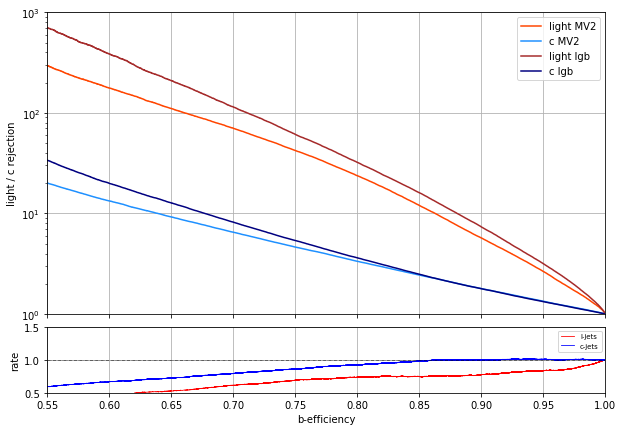

In [17]:
fig=plt.figure(figsize=(10,7))

gs=GridSpec(5,1)

ax1=fig.add_subplot(gs[0:4,0])
ax2=fig.add_subplot(gs[4,0])

ax1.set_ylabel("light / c rejection")
ax1.semilogy(tpr_l_mv, 1/fpr_l_mv, label='light MV2', c='orangered')
ax1.semilogy(tpr_c_mv, 1/fpr_c_mv, label='c MV2', c='dodgerblue')

ax1.semilogy(tpr_l_dnn, 1/fpr_l_dnn, label='light lgb', c='brown')
ax1.semilogy(tpr_c_dnn, 1/fpr_c_dnn, label='c lgb', c='navy')

plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_xlim([0.55, 1])
ax1.set_ylim([1, 1e3])

ax1.grid()
ax1.legend()

ax2.plot(tpr_l_dnn[1:], 1/rate_light, c='r', lw=.8,  label='l-jets')

ax2.plot(tpr_c_dnn[1:], 1/rate_c, c='b', lw=.8,  label='c-jets')

ax2.axhline(y=1, color='black', linestyle='-.', lw=.5)
ax2.grid()
ax2.set_xlabel("b-efficiency")
ax2.set_ylabel("rate")
ax2.set_xlim([0.55, 1])
ax2.set_ylim([0.5, 1.5])
ax2.legend(fontsize = 'x-small')

plt.savefig('figures/dnn_mv2_efficiency_vs_rejection.eps', format='eps')
plt.show()

C:\Users\leope\Desktop\projects_CERN\bob.py:146: RuntimeWarning: divide by zero encountered in true_divide
  l_rej = interpolate.spline(tpr, 1/fpr, 0.77, order=1)
C:\Users\leope\Desktop\projects_CERN\bob.py:150: RuntimeWarning: divide by zero encountered in true_divide
  l_rej = interpolate.spline(tpr, 1/fpr, 0.77, order=1)
C:\Users\leope\Desktop\projects_CERN\bob.py:160: RuntimeWarning: divide by zero encountered in true_divide
  c_rej = interpolate.spline(tpr, 1/fpr, 0.77, order=1)
C:\Users\leope\Desktop\projects_CERN\bob.py:163: RuntimeWarning: divide by zero encountered in true_divide
  c_rej = interpolate.spline(tpr, 1/fpr, 0.77, order=1)


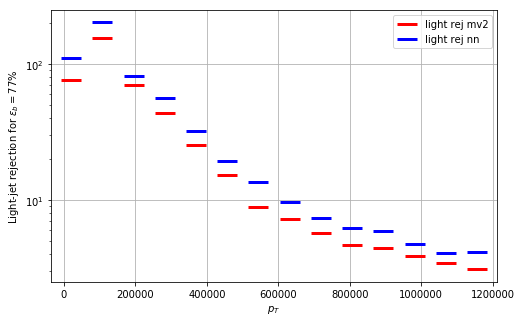

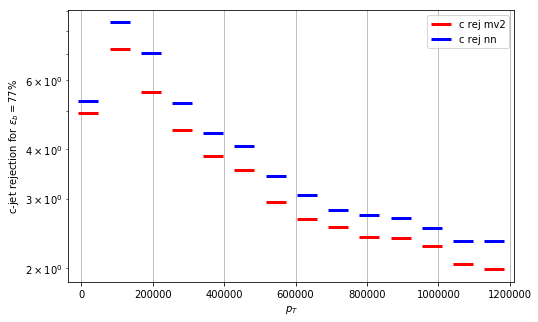

In [18]:
rejection_pt(test, test['jet_mv2c10'].values, ll, num_cuts=15)
plt.savefig('figures/dnn_mv2_rejection_vs_pt.eps', format='eps')
plt.show()